<a href="https://colab.research.google.com/github/nngu0123/ADS2002/blob/main/Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imputing Missing Data

In this notebook we investigate ways for dealing with missing data using Scikit-Learn's imputation routines. There are three main routines we will discuss: `SimpleImputer`, `KNNImputer` and `IterativeImputer`. We will only discuss imputing continuous, numerical values; for imputing categorical values possible approaches are using the mode or `KNNImputer`.

We will use the [Pima Indians Diabetes Dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database), which can be downloaded from [Monash Gitlab](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Machine-Learning/Imputation/pima_indians_diabetes.csv). This aims to predict whether the patient has diabetes from a number of diagnostic measurements. All patients are females of Pima Indian heritage, who are at least 21 years old.

Previously, we have dealt with missing data by deleting that entry. However, that means losing valuable data which contributes to the training of your model. A better approach is to impute the data, i.e., infer the missing data from the existing observations.

We will concentrate here on Scikit-Learn's imputation routines, although some of the techniques, such as replacement of values with the mean or mode, can be easily implemented in Pandas.

## Contents

* Introduction
* Preliminary analysis
* Cross-validation analysis
* Exercises

## Introduction

We first import the standard libraries and the csv file.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pima = pd.read_csv("pima_indians_diabetes.csv")

We can now view a random sample of the data. In the columns `BloodPressure`, `SkinThickness` and `Insulin` there are values of 0, which are clearly not physical. This is indicative of missing values.

In [2]:
pima.sample(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
427,1,181,64,30,180,34.1,0.328,38,1
328,2,102,86,36,120,45.5,0.127,23,1
313,3,113,50,10,85,29.5,0.626,25,0
298,14,100,78,25,184,36.6,0.412,46,1
433,2,139,75,0,0,25.6,0.167,29,0
625,4,90,88,47,54,37.7,0.362,29,0
633,1,128,82,17,183,27.5,0.115,22,0
11,10,168,74,0,0,38.0,0.537,34,1
203,2,99,70,16,44,20.4,0.235,27,0
235,4,171,72,0,0,43.6,0.479,26,1


This can be investigated further by displaying the descriptive statistics, for which it is apparent that `Glucose` and `BMI` also have unrealistic values of 0. A value of 0 for `Pregnancies` is a physically realistic value.

In [3]:
pima.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


To see how many 0 values there are in these fields, we can sum the number of rows which match this criteria. The two fields with the most missing values are `SkinThickness` and `Insulin`.

In [4]:
print((pima[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] == 0).sum())

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


Since 0 is a valid entry in `Pregnancies` and `Outcome`, we mark the missing values as NaN (not a number). This is the default for missing values for the sklearn imputation routines. Marking the values as NaN gives the same number of missing entries as previously.

In [5]:
pima[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = \
    pima[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)
print(pima.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


## Preliminary analysis

We now set up a simple random forest model to investigate the effect of a selection of different imputation methods on the accuracy, precision, recall and feature importance. Here the recall is the most significant metric, as we want to minimize false negatives (has diabetes, but not predicted). The function below creates a random forest model for the diabetes data, prints the metrics and feature importance in descending order.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

def rf_model(pimadf):
    Xf = pimadf.drop(columns=['Outcome'])
    Yf = np.ravel(pimadf[['Outcome']])

    X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size=0.2, random_state=0)
    rfc = RandomForestClassifier(random_state=0)
    rfc.fit(X_train, Y_train) # fit the data to the model
    Y_pred = rfc.predict(X_test)
    acc = accuracy_score(Y_test,Y_pred)
    prec = precision_score(Y_test,Y_pred)
    rec = recall_score(Y_test,Y_pred)
    print("\n")
    print("Testing scores are: accuracy {0:5.3f}, precision {1:5.3f}, recall {2:5.3f}" .format(acc,prec,rec))

    feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['Importance']).sort_values('Importance', ascending=False)
    print("\n")
    print(feature_importances)


The first example is to drop all rows which have a missing value. This results in approximately half of the dataset being dropped. For this data one of the most important features is `Insulin`, which is the feature with the most missing values.

In [7]:
pima_drop = pima.copy()
pima_drop.dropna(inplace=True)
print('Dropping rows')
print("\n")
print('Shape of array',pima_drop.shape)
print('Shape of original array',pima.shape)

rf_model(pima_drop)

Dropping rows


Shape of array (392, 9)
Shape of original array (768, 9)


Testing scores are: accuracy 0.785, precision 0.682, recall 0.600


                          Importance
Glucose                     0.249054
Insulin                     0.149633
Age                         0.141292
BMI                         0.118842
DiabetesPedigreeFunction    0.113555
SkinThickness               0.081439
BloodPressure               0.075061
Pregnancies                 0.071124


For reference we can plot the distribution of `Insulin` and `SkinThickness` to investigate how different imputation methods affect this. For the other features with missing values the distributions will not be significantly affected, and the exact imputation method probably is not critical to the model.

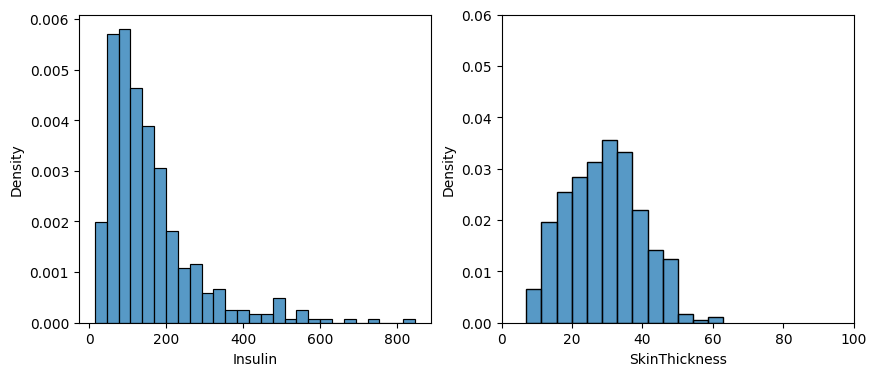

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.histplot(pima_drop, x="Insulin", stat="density", ax = axes[0])
sns.histplot(pima_drop, x="SkinThickness", stat="density", ax = axes[1])
axes[1].set_xlim(0,100)
axes[1].set_ylim(0,0.06);

Replacing the missing values with the mean or the median now results in an increase of all the metrics of the model, and the feature importance of `SkinThickness` and `Insulin` being ranked very low. This is understandable, as replacing the missing values with a constant results in the reduction of the variance of the feature.

In [9]:
pima_mean = pima.copy()
pima_mean.fillna(pima_mean.mean(), inplace=True)

print('Imputation using mean')
rf_model(pima_mean)

Imputation using mean


Testing scores are: accuracy 0.805, precision 0.689, recall 0.660


                          Importance
Glucose                     0.247231
BMI                         0.156630
Age                         0.145328
DiabetesPedigreeFunction    0.127873
Insulin                     0.086596
BloodPressure               0.084816
Pregnancies                 0.080150
SkinThickness               0.071375


In [10]:
pima_median = pima.copy()
pima_median.fillna(pima_mean.median(), inplace=True)

print('Imputation using median')
rf_model(pima_median)

Imputation using median


Testing scores are: accuracy 0.812, precision 0.696, recall 0.681


                          Importance
Glucose                     0.247677
BMI                         0.159408
Age                         0.144171
DiabetesPedigreeFunction    0.128357
Insulin                     0.085797
BloodPressure               0.084323
Pregnancies                 0.078018
SkinThickness               0.072250


This reduction in variance can be clearly seen by plotting the distributions of the mean and median datasets. For both, the plots are now dominated by a single peak.

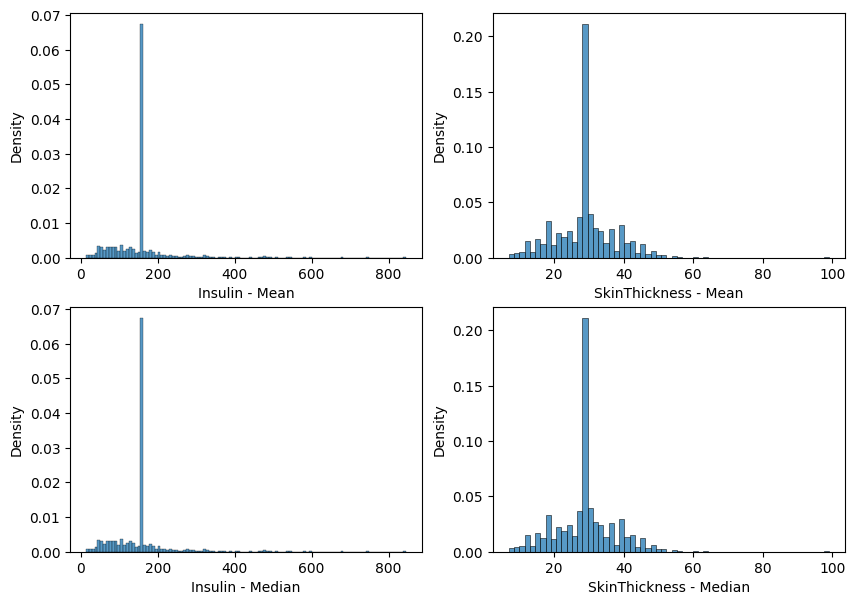

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10,7))

sns.histplot(pima_mean, x="Insulin", stat="density", ax = axes[0,0])
axes[0,0].set_xlabel('Insulin - Mean')
sns.histplot(pima_median, x="Insulin", stat="density", ax = axes[1,0])
axes[1,0].set_xlabel('Insulin - Median')
sns.histplot(pima_mean, x="SkinThickness", stat="density", ax = axes[0,1])
axes[0,1].set_xlabel('SkinThickness - Mean')
sns.histplot(pima_median, x="SkinThickness", stat="density", ax = axes[1,1])
axes[1,1].set_xlabel('SkinThickness - Median');

The first machine learning imputer we consider is the k-Nearest Neighbours imputer. This iterates through all the missing values, treating each one as a label, and then finds the corresponding label of its k-Nearest Neighbours. This will be affected by the distance metric that is used, the number of neighbours and the order that the features are imputed. In this case we use the default values and 5 neighbours.

The accuracy is slightly higher than for the dataset where we dropped the rows, and similar to using the mean and median. However, the ranking of features is more consistent with the original dataset, especially for `Insulin` and `SkinThickness`.

In [12]:
from sklearn.impute import KNNImputer

pima_knnn = pima.copy()
X = pima_knnn.iloc[:,0:8]
Xm = X.mean()
Xs = X.std()
X = (X-X.mean())/X.std()
Xt = KNNImputer(n_neighbors=5).fit_transform(X)
pima_knnn.iloc[:,0:8] = Xt

print('Imputation using k-Nearest Neighbours')
pima_knnn.iloc[:,0:8] = Xs*pima_knnn.iloc[:,0:8]+Xm
rf_model(pima_knnn)

Imputation using k-Nearest Neighbours


Testing scores are: accuracy 0.805, precision 0.698, recall 0.638


                          Importance
Glucose                     0.213634
Insulin                     0.151706
BMI                         0.145919
Age                         0.131440
DiabetesPedigreeFunction    0.113637
SkinThickness               0.098912
BloodPressure               0.072798
Pregnancies                 0.071954


The second method we consider is the sklearn `IterativeImputer`. This is an experimental addition to sklearn, so needs to be enabled as well as imported. As it is experimental, it may change in future versions.

`IterativeImputer` works be marking the missing values, and then repeating the imputation process N times or until the data converges. Initially the missing values are set using a simple scheme, such as being replaced by the mean or median. Then on each iteration a machine learning algorithm is used as a regressor to update each column which is marked as having missing values. The non-missing values are used to train the model, and then the model is used to predict the missing values. Any regression technique could be used to predict the missing values. Common ones that are used are BayesianRidge, k-Nearest Neighbours and Random Forest Regression. Using this algorithm with Random Forest Regression is equivalent to the R routine `missForest`. The routine `KNNImputer` is equivalent to `IterativeImputer` with one iteration.

In this example, we use the default algorithm, BayesianRidge. This gives that compared to the original dataset the accuracy and precision decreasel but the recall increases, however the feature importance is consistent with the original dataset and the results of `KNNImputer`.

In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

pima_ii = pima.copy()
X = pima_ii.iloc[:,0:8]
Xm = X.mean()
Xs = X.std()
X = (X-X.mean())/X.std()
Xt = IterativeImputer(max_iter=20, random_state=0).fit_transform(X)
pima_ii.iloc[:,0:8] = Xt

print('Iterative imputation using Bayesian Ridge')
pima_ii.iloc[:,0:8] = Xs*pima_ii.iloc[:,0:8]+Xm
rf_model(pima_ii)

Iterative imputation using Bayesian Ridge


Testing scores are: accuracy 0.773, precision 0.630, recall 0.617


                          Importance
Glucose                     0.207493
Insulin                     0.165304
BMI                         0.139473
Age                         0.126682
DiabetesPedigreeFunction    0.112677
SkinThickness               0.102626
BloodPressure               0.074122
Pregnancies                 0.071623


Plotting the distributions shows that the `KNNImputer` and `IterativeImputer` gives similar results for `Insulin`, but that `IterativeImputer` seems to give a distribution which is more consistent with the original dataset for `SkinThickness`.

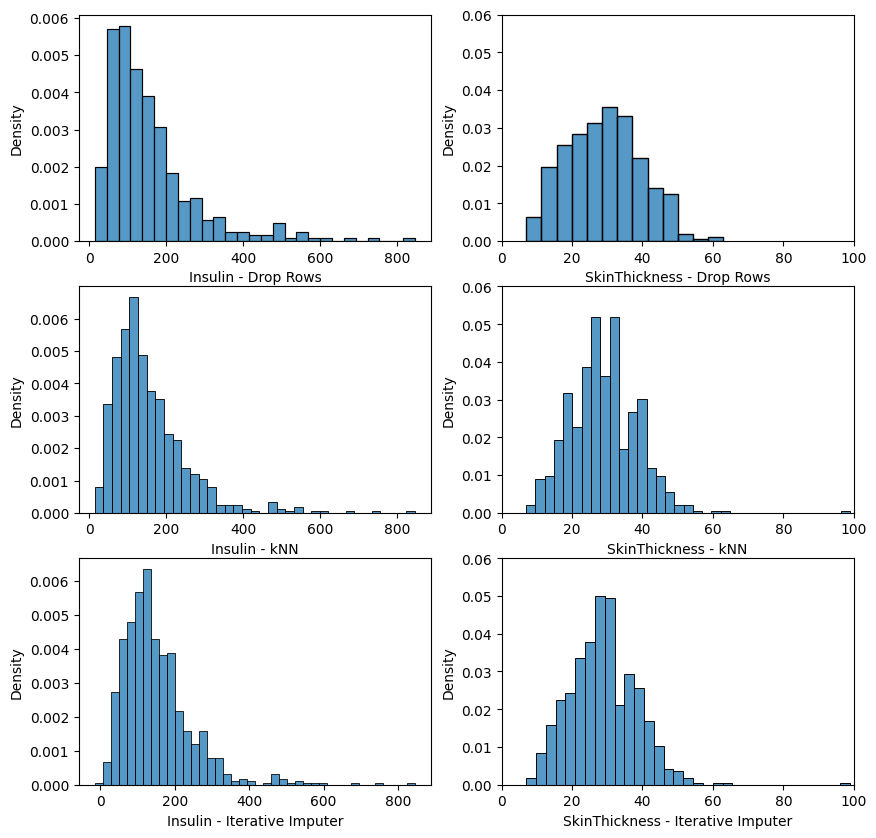

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(10,10))

sns.histplot(pima_drop, x="Insulin", stat="density", ax = axes[0,0])
axes[0,0].set_xlabel('Insulin - Drop Rows')
sns.histplot(pima_knnn, x="Insulin", stat="density", ax = axes[1,0])
axes[1,0].set_xlabel('Insulin - kNN')
sns.histplot(pima_ii, x="Insulin", stat="density", ax = axes[2,0])
axes[2,0].set_xlabel('Insulin - Iterative Imputer')
sns.histplot(pima_drop, x="SkinThickness", stat="density", ax = axes[0,1])
axes[0,1].set_xlabel('SkinThickness - Drop Rows')
axes[0,1].set_xlim(0,100)
axes[0,1].set_ylim(0,0.06)
sns.histplot(pima_knnn, x="SkinThickness", stat="density", ax = axes[1,1])
axes[1,1].set_xlabel('SkinThickness - kNN')
axes[1,1].set_xlim(0,100)
axes[1,1].set_ylim(0,0.06)
sns.histplot(pima_ii, x="SkinThickness", stat="density", ax = axes[2,1])
axes[2,1].set_xlabel('SkinThickness - Iterative Imputer')
axes[2,1].set_xlim(0,100)
axes[2,1].set_ylim(0,0.06);


## Cross-validation analysis

For all the examples so far we have only considered one realisation of the Random Forest Regressor. To understand the effectiveness of the various imputation algorithms we need to combine this with cross validation. The following code considers the variation of the recall using Logistic Regression for the imputation strategies:
* Drop rows with missing values.
* Simple imputation using the mean.
* Simple imputation using the median.
* k-Nearest Neighbours imputation.
* Iterative imputation using:
    * BayesianRidge,
    * DecisionTreeRegressor,
    * RandomForestRegressor,
    * k-Nearest Neighbours Regression.
    
The individual scores for each run are stored in a dataframe, for which we can finally investigate the descriptive statistics.

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold

N_SPLITS = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
classifier = LogisticRegression(solver='newton-cg', C=1.e3)
score = 'recall'

X_full = pima_drop.drop(columns=['Outcome'])
Y_full = np.ravel(pima_drop[['Outcome']])

score_drop = pd.DataFrame(
    cross_val_score(
        classifier, X_full, Y_full, scoring=score, cv=N_SPLITS
    ),
    columns=['Drop Data']
)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Estimate the score after imputation (mean and median strategies)
X_missing = pima.drop(columns=['Outcome'])
Y_missing = np.ravel(pima[['Outcome']])

score_simple_imputer = pd.DataFrame()
for strategy in ('mean', 'median'):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        classifier
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, Y_missing, scoring=score, cv=N_SPLITS
    )


In [ ]:
from sklearn.impute import KNNImputer

score_knn_imputer = pd.DataFrame()
estimator = make_pipeline(
    KNNImputer(n_neighbors=15),
    classifier
)
score_knn_imputer['KNeighborsRegressor'] = cross_val_score(
        estimator, X_missing, Y_missing, scoring=score, cv=N_SPLITS
)


In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(random_state=0),
    RandomForestRegressor(random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator, max_iter=10),
        classifier
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X_missing, Y_missing, scoring=score, cv=N_SPLITS
        )


We can now investigate the descriptive statistics for each imputation method in tabular and graphical format. The green dots in the figure represent the mean values for each method.

The first thing to note is that by using imputation with the full dataset, the variance of the model has been reduced significantly, which suggests that the `Drop Data` model suffers from overfitting. This is consistent with the fact that one way to reduce overfitting is to increase the amount of data. In general, as the complexity of the imputer is increased the accuracy also increases, though the result is dependent on the underlying strategy.

For this example, the best methods, i.e., those with the highest mean and lowest variance, for imputation seem to:
* kNN imputer.
* Iterative imputation using BayesianRidge.
    
As with all modelling, the final strategy for imputation depends on the model that you use, and should be decided on after extensive initial testing.

In [ ]:
scores = pd.concat(
    [score_drop, score_simple_imputer, score_knn_imputer, score_iterative_imputer],
    keys=['Original', 'SimpleImputer', 'KNN', 'IterativeImputer'], axis=1
)

scores.describe()

In [ ]:
# plot results
fig, ax = plt.subplots(figsize=(13, 6))
scores.plot.box(showmeans=True, vert=False, ax=ax)
ax.set_title('Pima Indian Diabetes Classification with Different Imputation Methods')
ax.set_xlabel('Accuracy (larger is better)')
plt.show()

## Exercises

For the exercises we will use the [Abalone Dataset](https://archive.ics.uci.edu/ml/datasets/Abalone), which can be downloaded from [Monash Gitlab](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Machine-Learning/Imputation/abalone.csv). This consists of physical measurements of abalones from the Tasmanian coast in the 1990s, in an effort to determine their age. Previously the age would need to be determined in the laboratory by counting the number of rings in the shell. Then $Age = Rings + 1.5$. This is a complete dataset, however we will randomly remove entries in two columns to perform imputation.

First we load the dataset.

In [ ]:
abalone = pd.read_csv("abalone.csv")
abalone.head()

The `Sex` field has three categorical entries: Male (M), Female (F) and Infant (I). Se we need to one-hot encode these fields to create three binary columns.

In [ ]:
dummy = pd.get_dummies(abalone['Sex'])
abalone = pd.concat([abalone, dummy], axis=1)
abalone.drop(columns=['Sex'], inplace=True)
abalone.head()

Last we create a features array (Xf) and a label array (Yf). Then we randomly remove 33% of the `Height` samples and 25% of the `Shell weight` samples from the features array.

In [ ]:
Xf = abalone.drop(columns=['Rings'])
Yf = abalone[['Rings']]

X = Xf.copy()
X['Height'] = X['Height'].sample(frac=0.67)
X['Shell weight'] = X['Shell weight'].sample(frac=0.75)

X.describe()

### Exercise 1 (2 marks)

Create a Random Forest Regressor model for the full dataset and determine the accuracy of this model. Use an 80:20 split for training and testing.

In [ ]:
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.metrics import r2_score

Xf = abalone.drop(columns=['Rings'])
Yf = abalone[['Rings']]

X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size=0.2, random_state=0)
rfc = RandomForestRegressor()
rfc.fit(X_train, Y_train) # fit the data to the model
Y_pred = rfc.predict(X_test)
acc = r2_score(Y_test,Y_pred)
print("Testing score is %5.3f" % acc)

### Exercise 2 (3 marks)

Fill in the missing values of X using `IterativeImputer` with 10 iterations and using the `BayesianRidge` regressor. Calculate the accuracy of the Random Forest Regressor using this imputed dataset.

In [ ]:
Xt = IterativeImputer(random_state=0, max_iter=10).fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(Xt, Yf, test_size=0.2, random_state=0)
rfc = RandomForestRegressor()
rfc.fit(X_train, Y_train) # fit the data to the model
Y_pred = rfc.predict(X_test)
acc = r2_score(Y_test,Y_pred)
print("Testing score is %5.3f" % acc)

### Exercise 3 (5 marks)

Fill in the missing values of X using `IterativeImputer` with 10 iterations and using `KNeighborsRegressor` for 5, 10, 15 and 20 neighbours. Calculate the accuracy of the Random Forest Regressor using each of these imputed datasets.

In [ ]:
for n in (5, 10, 15, 20):
    Xt = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=n),
                      random_state=0, max_iter=10).fit_transform(X)

    X_train, X_test, Y_train, Y_test = train_test_split(Xt, Yf, test_size=0.2, random_state=0)
    rfc = RandomForestRegressor()
    rfc.fit(X_train, Y_train) # fit the data to the model
    Y_pred = rfc.predict(X_test)
    acc = r2_score(Y_test,Y_pred)
    print("Neighbours",n)
    print("Testing score is %5.3f" % acc)

### Generative AI Acknowledgement

If you used generative AI to assist you with these excercises, document your use below following the guidelines here: https://www.monash.edu/learnhq/build-digital-capabilities/create-online/acknowledging-the-use-of-generative-artificial-intelligence